# URL Classification with Support Vector Machine (SVM)
This notebook implements URL classification (malicious URL detection) using SVM algorithm.
It includes comprehensive feature engineering, feature scaling, and model evaluation.

## 1. Import Libraries

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from tld import get_tld
import os.path
from googlesearch import search

# ML libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix
import joblib
from wordcloud import WordCloud

# Cuda core
# from thundersvm import SVC as ThunderSVC

# import warnings
# warnings.filterwarnings('ignore')

# CONFIG
APP_NAME='Malsy Gate'
DATA_PATH = "../artifacts/dataset/data.csv"
ATTATCH_PATH="../code/attatch"

MATRICS_PATH="../code/exports/matrics"
MODEL_PATH="../code/exports/models"
LABLE_PATH="../code/exports/labels"

## 2. Load Dataset

In [ ]:
# Load the Dataset
df = pd.read_csv(DATA_PATH, )
print(f"Dataset shape: {df.shape}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nDataset head:")
df.head()

Dataset shape: (651191, 2)

Dataset columns: ['url', 'type']

Dataset head:


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [39]:
# Check data types and null values
print("Data Info:")
df.info()
print("\nNull values:")
print(df.isnull().sum())
print("\nTarget distribution:")
print(df['type'].value_counts())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB

Null values:
url     0
type    0
dtype: int64

Target distribution:
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


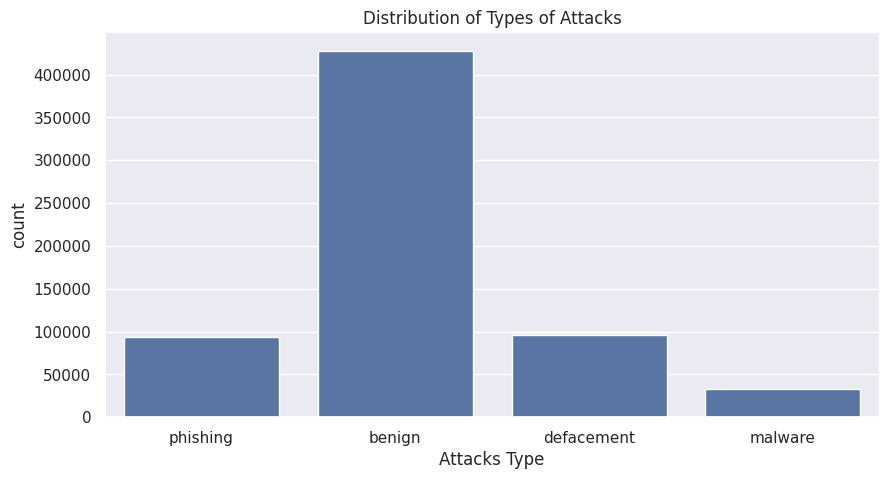

In [40]:
plt.figure(figsize= (10 , 5))
plt.title('Distribution of Types of Attacks')
sns.countplot(x = 'type', data = df)
# ax.bar_label(ax.containers[0])
plt.xlabel('Attacks Type')

plt.savefig(ATTATCH_PATH + '/type_of_accatck.png', bbox_inches='tight')

### WordCloud of Different Types of Attacks

In [41]:
df_phish = df[df['type'] == 'phishing']
df_benign = df[df['type'] == 'benign']
df_deface = df[df['type'] == 'defacement']
df_malware = df[df['type'] == 'malware']

**Phishing Url**

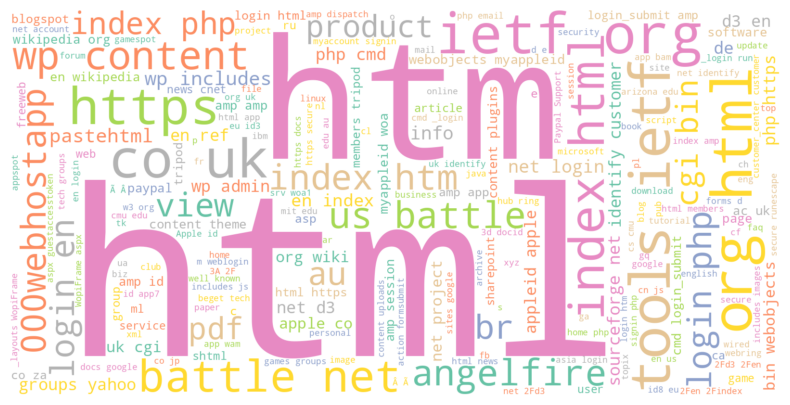

In [86]:
phish_url = " ".join(i for i in df_phish.url)
# print(phish_url[0: 1000])
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",  
    colormap="Set2", 
    
).generate(phish_url)

wordcloud.to_file(ATTATCH_PATH + '/phish_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Benign Url**

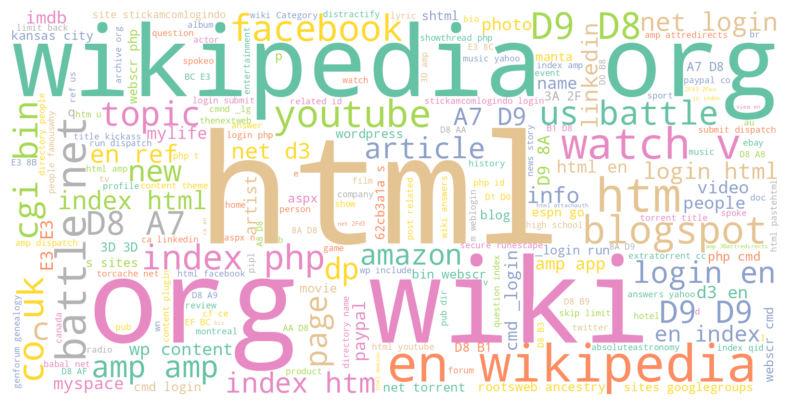

In [ ]:
benign_url = " ".join(i for i in df_benign.url)

wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    colormap="Set2",
).generate(benign_url)

wordcloud.to_file(ATTATCH_PATH + '/benign_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Defracment Url**

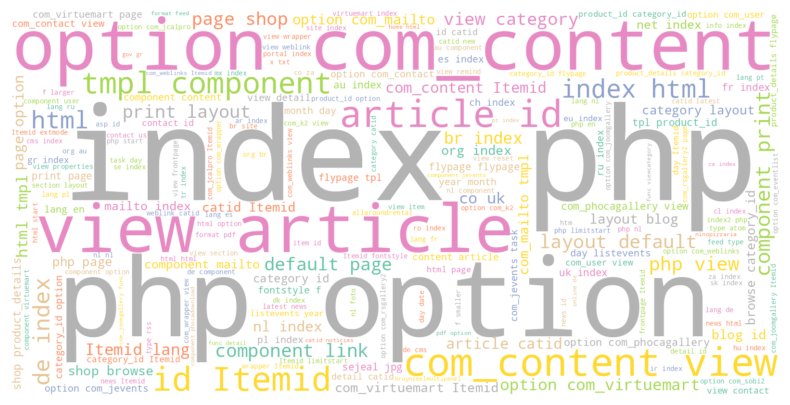

In [83]:
deface_url = " ".join(i for i in df_deface.url)

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",  
    colormap="Set2", 
    
).generate(deface_url)

wordcloud.to_file(ATTATCH_PATH + '/deface_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Malware**

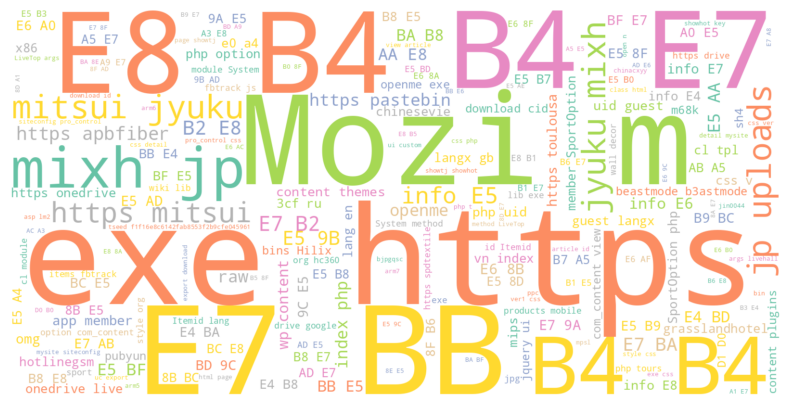

In [84]:
malware_url = " ".join(i for i in df_malware.url)

wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color="white",  
    colormap="Set2", 
    
).generate(malware_url)

wordcloud.to_file(ATTATCH_PATH + '/malware_wordcloud.png')

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Feature Extraction

extract the following lexical features from raw URLs, as these features will be used as the input features for training the machine learning model. The following features are created as follows:

### 3.1 IP Address Detection

In [46]:
# Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    
    if match:
        return 1
    else:
        return 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))
print(df['use_of_ip'].value_counts())

use_of_ip
0    643898
1      7293
Name: count, dtype: int64


In [47]:
df[df['use_of_ip'] == 1]

,url,type,use_of_ip
10408,http://219.232.244.89/intl/update/error_login.htm,phishing,1
12441,boards.ancestry.com/topics.ethnic.natam.nation...,benign,1
12853,http://www.controlyourbreath.com/new/css_/img/...,phishing,1
13161,http://www.reqntpvw.com/Public/softs/everythin...,malware,1
14915,http://66.208.115.70/images/index.asp,phishing,1
...,...,...,...
598624,helapharm.ro/css_/img/webscr/cmd_/e2tUc17DNO4H...,benign,1
598638,helapharm.ro/css_/img/webscr/cmd_/e2tUc17DNO4H...,benign,1
601657,www.mairie-saint-avold.fr/admin/125.14.226.143...,benign,1
601697,www.mairie-saint-avold.fr/admin/190.244.107.16...,benign,1


Text(0.5, 1.0, 'Malsy Gate - Usage of Ip Address')

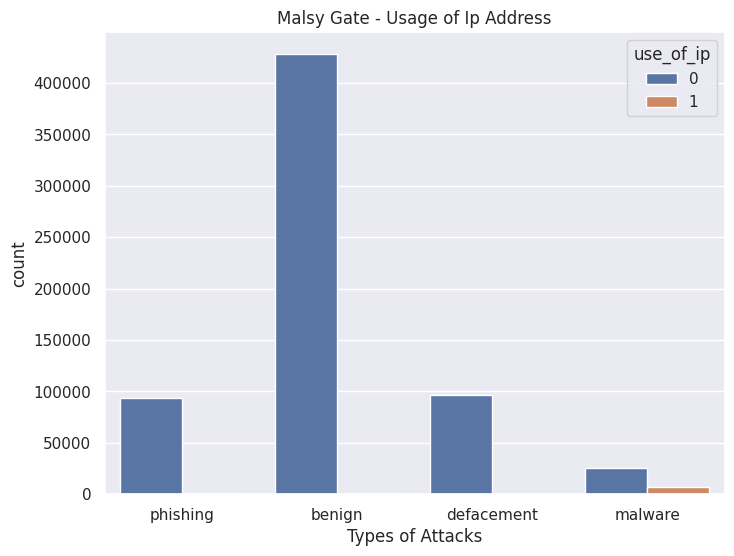

In [48]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=df, hue="use_of_ip")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + " - Usage of Ip Address")

**Shape data**

In [49]:
arr = np.where(df[df['type'] == 'benign']['use_of_ip'] == 1)
arr[0].shape

(89,)

In [50]:
arr = np.where(df[df['type'] == 'malware']['use_of_ip'] == 1)
arr[0].shape

(6870,)

In [51]:
arr = np.where(df[df['type'] == 'phishing']['use_of_ip'] == 1)
arr[0].shape

(334,)

In [52]:
arr = np.where(df[df['type'] == 'defacement']['use_of_ip'] == 1)
arr[0].shape

(0,)

### 3.2 Abnormal URL

In [53]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:      
        return 1
    else:
        return 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
print(df['abnormal_url'].value_counts())

abnormal_url
0    463185
1    188006
Name: count, dtype: int64


Text(0.5, 1.0, 'Malsy Gate- Usage of Ip Address in domain name in with Diffrent types of attacks')

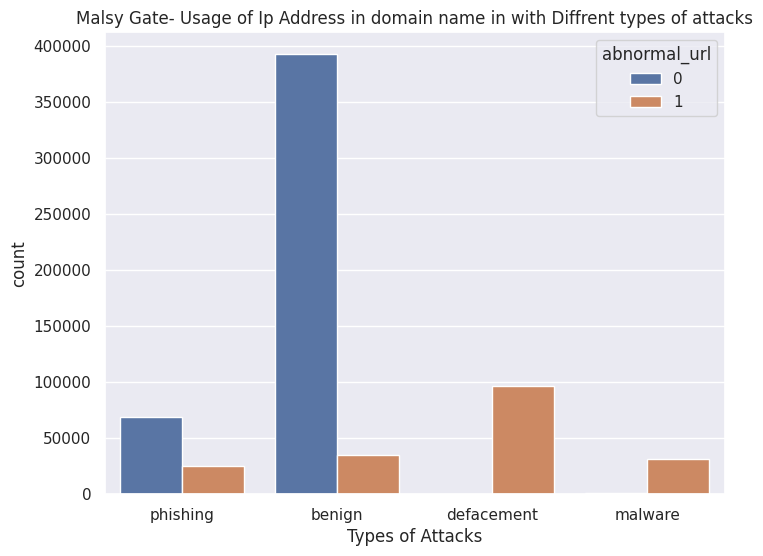

In [54]:
plt.figure(figsize = (8 , 6))
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=df, hue="abnormal_url")
plt.xlabel('Types of Attacks')
plt.title(APP_NAME + "- Usage of Ip Address in domain name in with Diffrent types of attacks")

**Shape data**

In [55]:
arr = df[df['type'] == 'benign']['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
0    392709
1     35394
Name: count, dtype: int64


In [56]:
arr = df[df['type'] == 'phishing']['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
0    69266
1    24845
Name: count, dtype: int64


In [57]:
arr = df[df['type'] == 'defacement']['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
1    96457
Name: count, dtype: int64


In [58]:
arr = df[df['type'] == 'malware']['abnormal_url'].value_counts()

print(arr)

# arr[0].shape
# arr

abnormal_url
1    31310
0     1210
Name: count, dtype: int64


### 3.3 Google Index

In [59]:
def google_index(url):
    
    site = search(url, 5)
    return 1 if site else 0

df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [60]:
print(df['url'][0])
for j in search(df['url'][0], num_results=10):
    print(j)

br-icloud.com.br
https://www.apple.com/br/icloud/
https://www.icloud.com.br/
https://www.icloud.com/
https://www.icloud.com/plan
https://www.icloud.com.br/iniciar-sessao
https://www.icloud.com/photos
https://apps.microsoft.com/detail/9pktq5699m62?hl=pt-BR
https://www.icloud.com/mail
https://www.icloud.com/iclouddrive
https://www.reddit.com/r/applehelp/comments/1fw8g11/why_does_my_iphone_always_default_to_icloudcom/?tl=pt-br


In [61]:
df['google_index'].value_counts()

google_index
1    651191
Name: count, dtype: int64

### 3.4 Count Features

In [62]:
# Count dot (.)
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count_.'] = df['url'].apply(lambda i: count_dot(i))

# Count www
def count_www(url):
    url.count('www')
    return url.count('www')

df['count_www'] = df['url'].apply(lambda i: count_www(i))

# Count @
def count_atrate(url):
    return url.count('@')

df['count_@'] = df['url'].apply(lambda i: count_atrate(i))

# Count directories
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

# Count embedded domains
def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))



Text(0.5, 1.0, 'Malsy Gate - No. Of Dots Available in URLS ')

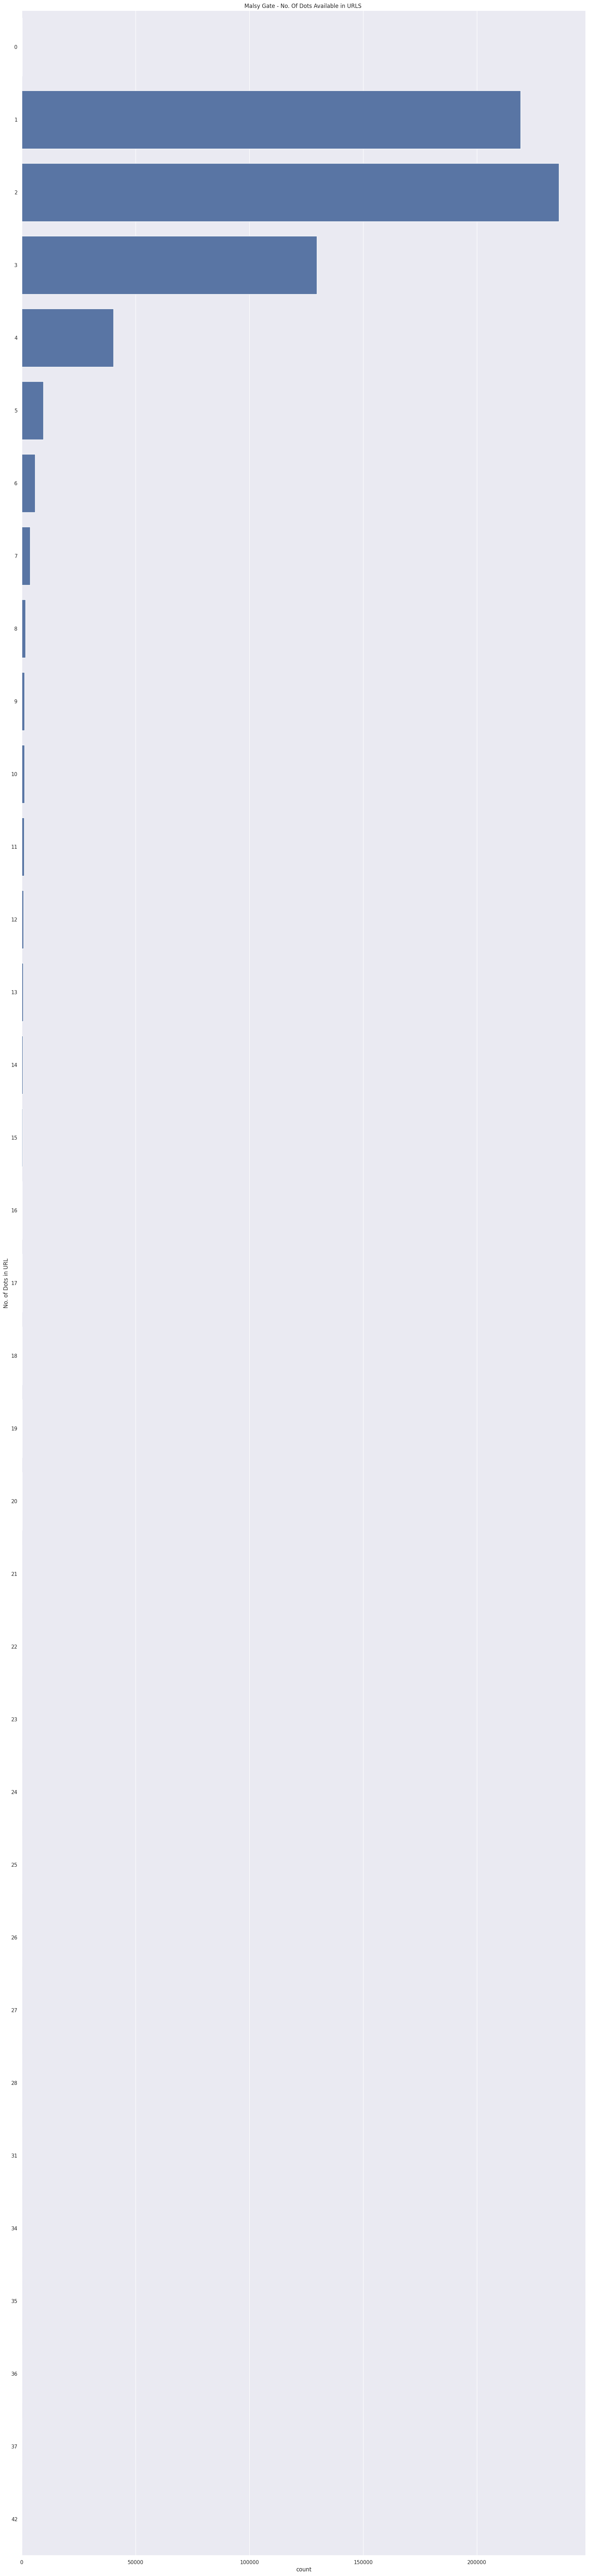

In [63]:
plt.figure(figsize = (22 , 100))
sns.set(style="darkgrid")
ax = sns.countplot(y="count_.", data=df)
plt.ylabel('No. of Dots in URL')
plt.title(APP_NAME + " - No. Of Dots Available in URLS ")

### 3.5 Suspicious Words Detection

In [64]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))

### 3.6 URL Shortening Service Detection

In [65]:
def shortening_service(url):
    match = re.search(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      r'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

### 3.7 Protocol Counts

In [66]:
# Count https
def count_https(url):
    return url.count('https')

df['count_https'] = df['url'].apply(lambda i: count_https(i))

# Count http
def count_http(url):
    return url.count('http')

df['count_http'] = df['url'].apply(lambda i: count_http(i))

### 3.8 Special Character Counts

In [67]:
# Count %
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i: count_per(i))

# Count ?
def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

# Count -
def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

# Count =
def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

### 3.9 Length Features

In [68]:
# URL length
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))

# Hostname length
def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

### 3.10 Domain Features

In [69]:
# First directory length
def fd_length(url):
    urlpath = urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# TLD length
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld'] = df['url'].apply(lambda i: get_tld(i, fail_silently=True))
df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df = df.drop("tld", axis=1)

### 3.11 Character Counts

In [70]:
# Count digits
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['count_digits'] = df['url'].apply(lambda i: digit_count(i))

# Count letters
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count_letters'] = df['url'].apply(lambda i: letter_count(i))

## 4. Label Encoding

In [71]:
# Label Encoding
label_encoder = LabelEncoder()
df['type_code'] = label_encoder.fit_transform(df['type'])

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")

print("\nTarget distribution after encoding:")
print(df['type_code'].value_counts())

Label mapping:
benign: 0
defacement: 1
malware: 2
phishing: 3

Target distribution after encoding:
type_code
0    428103
1     96457
3     94111
2     32520
Name: count, dtype: int64


## 5. Feature and Target Creation

In [72]:
# Create feature matrix X and target vector Y
X = df[['use_of_ip','abnormal_url', 'count_.', 'count_www', 'count_@',
       'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 
       'count-', 'count=', 'url_length', 'count_https', 'count_http', 
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits',
       'count_letters']]

Y = df['type_code']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {Y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

Feature matrix shape: (651191, 21)
Target vector shape: (651191,)

Features: ['use_of_ip', 'abnormal_url', 'count_.', 'count_www', 'count_@', 'count_dir', 'count_embed_domain', 'short_url', 'count%', 'count?', 'count-', 'count=', 'url_length', 'count_https', 'count_http', 'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count_digits', 'count_letters']


In [ ]:
MAXIMUM_ROW=20

plt.figure(figsize=(12,6))
plt.imshow(X.head(MAXIMUM_ROW), aspect='auto', cmap="viridis")
plt.colorbar(label="Value")
plt.yticks(range(MAXIMUM_ROW), [f"Row {i}" for i in range(MAXIMUM_ROW)])
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.title("Feature Matrix (first " + MAXIMUM_ROW +" rows)")
plt.show()

## 6. Train-Test Split

In [73]:
# Split the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTraining target distribution:")
print(Y_train.value_counts())
print(f"\nTest target distribution:")
print(Y_test.value_counts())

Training set size: (520952, 21)
Test set size: (130239, 21)

Training target distribution:
type_code
0    342325
1     77353
3     75275
2     25999
Name: count, dtype: int64

Test target distribution:
type_code
0    85778
1    19104
3    18836
2     6521
Name: count, dtype: int64


## 7. Feature Scaling
SVM requires feature scaling for optimal performance.

In [74]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data (using the same scaler fitted on training data)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Feature scaling completed!
Scaled training set shape: (520952, 21)
Scaled test set shape: (130239, 21)


## 8. SVM Model

In [75]:
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)

# svm_model = ThunderSVC(
#     kernel='rbf',
#     C=1.0,
#     # default gpu = 0: primary gpu, 1: secondary gpu
#     gpu_id=0,
#     probability=True,
#     random_state=42
# )

print("Training SVM model...")
print("This may take a few minutes...")
svm_model.fit(X_train_scaled, Y_train)
print("Training complete!")

Training SVM model...
This may take a few minutes...
Training complete!


## 9. Model Evaluation

In [76]:
# Predictions
Y_pred_train = svm_model.predict(X_train_scaled)
Y_pred_test = svm_model.predict(X_test_scaled)

# Metrics
train_accuracy = accuracy_score(Y_train, Y_pred_train) * 100
test_accuracy = accuracy_score(Y_test, Y_pred_test) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Detailed classification report
print("\n" + "="*50)
print("Classification Report (Test Set)")
print("="*50)
print(classification_report(Y_test, Y_pred_test, target_names=label_encoder.classes_))

Training Accuracy: 94.41%
Test Accuracy: 94.32%

Classification Report (Test Set)
              precision    recall  f1-score   support

      benign       0.96      0.99      0.97     85778
  defacement       0.93      0.97      0.95     19104
     malware       0.95      0.84      0.90      6521
    phishing       0.88      0.75      0.81     18836

    accuracy                           0.94    130239
   macro avg       0.93      0.89      0.91    130239
weighted avg       0.94      0.94      0.94    130239



## 10. Confusion Matrix

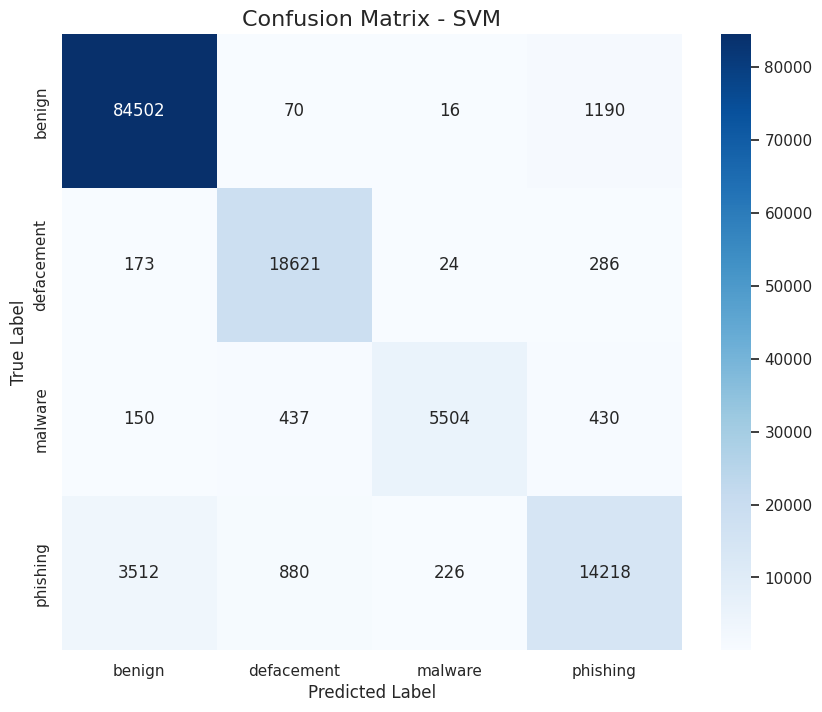

Confusion Matrix:
[[84502    70    16  1190]
 [  173 18621    24   286]
 [  150   437  5504   430]
 [ 3512   880   226 14218]]


In [77]:
# Create confusion matrix
cm = confusion_matrix(Y_test, Y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

## 11. Model Export

In [78]:
# Save the model
model_filename = 'svm_model.pkl'
joblib.dump(svm_model, MODEL_PATH + "/" + model_filename)
print(f"Model saved as: {model_filename}")

# Save the scaler
scaler_filename = 'svm_scaler.pkl'
joblib.dump(scaler, MODEL_PATH + "/" + scaler_filename)
print(f"Scaler saved as: {scaler_filename}")

# Save the label encoder
encoder_filename = 'label_encoder_svm.pkl'
joblib.dump(label_encoder, LABLE_PATH + "/" + encoder_filename)
print(f"Label encoder saved as: {encoder_filename}")

# Save model performance metrics
metrics = {
    'model': 'SVM',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'kernel': 'rbf',
    'C': 1.0,
    'random_state': 42
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(MATRICS_PATH + "/" + 'svm_model_metrics.csv', index=False)
print(f"Metrics saved to: svm_model_metrics.csv")

Model saved as: best_svm_model.pkl
Scaler saved as: svm_scaler.pkl
Label encoder saved as: label_encoder_svm.pkl
Metrics saved to: svm_model_metrics.csv


## 12. Summary

In [79]:
print("="*60)
print("SVM MODEL SUMMARY")
print("="*60)
print(f"Algorithm: Support Vector Machine")
print(f"Kernel: RBF")
print(f"Regularization (C): 1.0")
print(f"Number of Features: {X.shape[1]}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Test Samples: {X_test.shape[0]}")
print(f"\nPerformance:")
print(f"  - Training Accuracy: {train_accuracy:.2f}%")
print(f"  - Test Accuracy: {test_accuracy:.2f}%")
print(f"\nModel saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")
print("="*60)

SVM MODEL SUMMARY
Algorithm: Support Vector Machine
Kernel: RBF
Regularization (C): 1.0
Number of Features: 21
Training Samples: 520952
Test Samples: 130239

Performance:
  - Training Accuracy: 94.41%
  - Test Accuracy: 94.32%

Model saved as: best_svm_model.pkl
Scaler saved as: svm_scaler.pkl
